In [5]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
# can try doing addfiles to spark init in nb_spark - maybe terminal option for files
from src import EDA, ModelEvaluation, Preprocess, Split
%load_ext autoreload
%autoreload 2

spark_session = SparkSession.builder.getOrCreate()

In [14]:
# need holdout users.  Hold out 10%.  We could put some percent of their games into
# the training but it will make it very complicated
steam_df = EDA.load_200k()
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.process_general()
preprocessor.process_buckets()
preprocessor.process_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
max_score = steam_df['playtime_min_max'].max()
steam_df['random_prediction'] = get_random_scores(steam_df.shape[0], max_score)
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))
train_val.head(2)

split sizes:  (62791, 7698)


,uid,playtime,playtime_min_max,game_name,game_uid,random_prediction
1,151603712,273.0,0.412256,The Elder Scrolls V Skyrim,0,2.314122
3,151603712,87.0,0.414122,Fallout 4,1,2.970704


In [15]:
def get_random_scores(n, max_score):
    return np.random.random_sample(n, ) * max_score

def create_dataset(df, min_games_played=0, min_users_for_game=0):
    df = EDA.restrict_user_item(df, min_games_played=min_games_played, min_users_for_game=min_users_for_game)
    pandas_train_test = Split.PandasTrainTest(df, seed=1)
    k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=.3)
    print('first train test split size: {}, {} '.format(k_fold_dfs[0][0].shape[0], k_fold_dfs[0][1].shape[0]))
    sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]
    return sparkified_k_fold_dfs

In [8]:
# we leave more than the top sorted by prediction because the actual may be n away from the 
# top predictions
def sort_predictions_slice(arr, n):
    actual_and_pred = np.array(arr)
    # sort by predictions
    indeces = np.argsort(actual_and_pred[:, 1])
    return actual_and_pred[indeces[::-1]][:n].tolist()

def dcg_at_k(scores, k):
    """
    Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    r = np.asfarray(scores)[:k]
    if r.size:
        # item 1 and 2 have same weights
        # return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # use below for more emphasis on first rank
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    print('sersly?')
    return 0.

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(scores, k) / dcg_max

def get_rdd_ndcg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 1000))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .sum()
    return rdd_ndcg

def fit_and_calculate_kfold_ndcg(model, train_test_dfs, top_n=5):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        predictions_rdd = predictions.rdd
        ndcg = get_rdd_ndcg(predictions_rdd, top_n=top_n, prediction_col='prediction')
        # can divide ndcg by user count - would be more efficient to pass counts
        num_users = len(predictions.groupby('uid').count().collect())
        results.append(ndcg / num_users)
    return sum(results) / len(results)

def fit_and_predict_kfold(model, train_test_dfs):
    prediction_rdds = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        prediction_rdd = predictions.rdd
        prediction_rdds.append(prediction_rdd)
    return prediction_rdds

def get_ndcg_and_random_ndcg(dataset):
    k_fold_prediction_rdds = fit_and_predict_kfold(als_model, dataset)
    ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
    random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
    ndcg = sum(ndcgs) / len(ndcgs)
    random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
    print('ndcg: ', ndcg)
    print('random_ndcg: ', random_ndcg)
    return (ndcg, random_ndcg)

In [9]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10
);

In [17]:
base_case = create_dataset(train_val, min_games_played=0, min_users_for_game=0)
get_ndcg_and_random_ndcg(base_case)

Number of users:  10215
first train test split size 53164, 9627: 
ndcg:  431.024559748
random_ndcg:  365.709611512


(431.02455974834868, 365.70961151170661)

## Cold Start for Users

In [ ]:
min_games_played_datasets1 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(1,10)]

In [20]:
# prediction vs random_prediction ndcg
user_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets1]
user_increase1 = [((predicted / random) - 1) * 100 for predicted, random in user_results1]

ndcg:  431.024559748
random_ndcg:  365.709611512
ndcg:  426.150640534
random_ndcg:  363.214365998
ndcg:  427.690077312
random_ndcg:  362.533219841
ndcg:  325.154006477
random_ndcg:  263.271049074
ndcg:  263.827389752
random_ndcg:  210.020082089
ndcg:  219.223411865
random_ndcg:  168.768726783
ndcg:  186.867872024
random_ndcg:  138.781498671
ndcg:  163.929897318
random_ndcg:  121.201318144
ndcg:  147.792840053
random_ndcg:  104.767347795


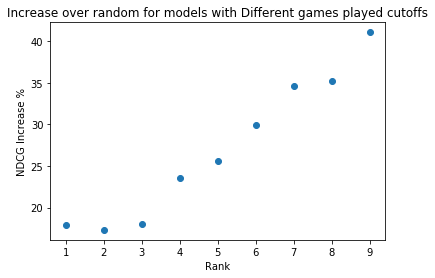

In [22]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), user_increase1)
ax.set_title('Increase over random for models with Different games played cutoffs')
ax.set_xlabel('Rank')
ax.set_ylabel('NDCG Increase %')
fig.show()

In [23]:
min_games_played_datasets2 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(10,20)]

Number of users:  1339
first train test split size 38833, 6926: 
Number of users:  1243
first train test split size 38194, 6564: 
Number of users:  1155
first train test split size 37895, 5936: 
Number of users:  1094
first train test split size 37177, 5922: 
Number of users:  1017
first train test split size 36543, 5431: 
Number of users:  962
first train test split size 35763, 5520: 
Number of users:  889
first train test split size 34761, 5472: 
Number of users:  838
first train test split size 33951, 5352: 
Number of users:  789
first train test split size 32919, 5665: 
Number of users:  748
first train test split size 31899, 5829: 


In [24]:
# prediction vs random_prediction ndcg
user_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets2]
user_increase2 = [((predicted / random) - 1) * 100 for predicted, random in user_results2]

ndcg:  129.388139867
random_ndcg:  89.6402410141
ndcg:  116.755643929
random_ndcg:  79.8550472443
ndcg:  104.787068903
random_ndcg:  69.692519045
ndcg:  99.0230179735
random_ndcg:  64.9100810411
ndcg:  90.6627332092
random_ndcg:  58.6337442694
ndcg:  84.0846961125
random_ndcg:  55.179307183
ndcg:  73.6182060266
random_ndcg:  48.535064047
ndcg:  68.3411702537
random_ndcg:  43.9102068073
ndcg:  64.5049908406
random_ndcg:  40.8382774438
ndcg:  59.4235650916
random_ndcg:  38.0640034965


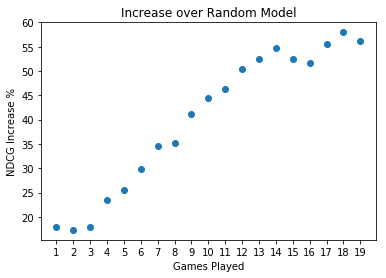

In [32]:
user_increases = user_increase1 + user_increase2
# user_abs
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), user_increases)
ax.set_xticks(list(range(1,20)))
ax.set_title('Increase over Random Model')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG Increase %')
fig.show()
# fig.savefig('../figures/increase_games_played.png')

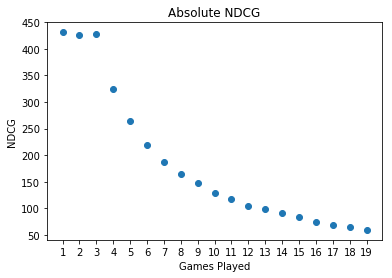

In [34]:
user_results = user_results1 + user_results2
absolute_increase = np.array(user_results)[:,0]
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), absolute_increase)
ax.set_xticks(list(range(1,20)))
ax.set_title('Absolute NDCG')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG')
fig.show()
# fig.savefig('../figures/absolute_games_played.png')

## Cold Start for Items

In [45]:
min_user_counts_datasets1 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(1,10)]

split sizes:  (61872, 7599)
Number of users:  10197
train test split size 0:  (52895, 8975)
train test split size 1:  (52798, 9072)
train test split size 2:  (52853, 9017)
train test split size 3:  (52158, 9712)
train test split size 4:  (52495, 9375)
split sizes:  (61950, 6593)
Number of users:  10184
train test split size 0:  (52966, 8984)
train test split size 1:  (52888, 9062)
train test split size 2:  (52922, 9028)
train test split size 3:  (52337, 9613)
train test split size 4:  (52413, 9537)
split sizes:  (62111, 5496)
Number of users:  10166
train test split size 0:  (52664, 9446)
train test split size 1:  (53646, 8464)
train test split size 2:  (53266, 8844)
train test split size 3:  (51863, 10247)
train test split size 4:  (52795, 9315)
split sizes:  (59179, 7540)
Number of users:  10149
train test split size 0:  (50189, 8990)
train test split size 1:  (50835, 8344)
train test split size 2:  (50358, 8821)
train test split size 3:  (50197, 8982)
train test split size 4:  (5006

In [46]:
# prediction vs random_prediction ndcg
item_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets1]
item_increase1 = [((predicted / random) - 1) * 100 for predicted, random in item_results1]

ndcg:  429.6666117
random_ndcg:  364.003091059
ndcg:  425.309861075
random_ndcg:  362.19947297
ndcg:  434.253536305
random_ndcg:  360.878323465
ndcg:  428.574219563
random_ndcg:  362.773415129
ndcg:  433.423561435
random_ndcg:  358.812393461
ndcg:  429.939565448
random_ndcg:  357.310703928
ndcg:  430.412047725
random_ndcg:  359.102308
ndcg:  424.794156649
random_ndcg:  355.568758652
ndcg:  425.587869716
random_ndcg:  351.336311442


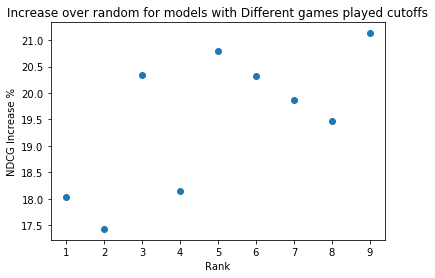

In [48]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), item_increase1)
ax.set_title('Increase over random for models with Different games played cutoffs')
ax.set_xlabel('Rank')
ax.set_ylabel('NDCG Increase %')
fig.show()

In [ ]:
min_user_counts_datasets2 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(10,20)]

Number of users:  10034
first train test split size 46900, 8153: 
Number of users:  10015
first train test split size 45940, 8420: 
Number of users:  10005
first train test split size 45850, 7910: 
Number of users:  9987
first train test split size 45183, 7895: 


In [45]:
# prediction vs random_prediction ndcg
item_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets2]
item_increase2 = [((predicted / random) - 1) * 100 for predicted, random in item_results2]

ndcg:  262.679643418
random_ndcg:  209.948573308
ndcg:  266.983306767
random_ndcg:  209.001654708
ndcg:  269.374851085
random_ndcg:  210.727566581
ndcg:  272.285738912
random_ndcg:  209.438884602
ndcg:  273.866233652
random_ndcg:  208.469486767
ndcg:  276.811011242
random_ndcg:  213.611364461
ndcg:  277.075475878
random_ndcg:  215.006543934
ndcg:  279.846853137
random_ndcg:  213.863217545
ndcg:  279.266932282
random_ndcg:  213.950020824


/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


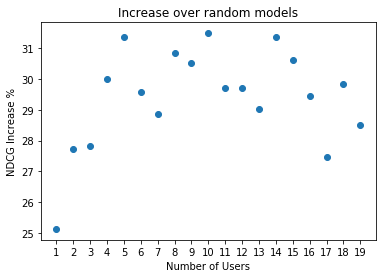

In [62]:
increases = first_item_increase + second_item_increase
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), increases)
ax.set_title('Increase over random models')
ax.set_xlabel('Number of Users')
ax.set_ylabel('NDCG Increase %')
ax.set_xticks(list(range(1,20)))
fig.show()
# fig.savefig('../figures/increase_users_for_items.png')

In [19]:
increases = first_increase + second_increase
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), increases[1:])
ax.set_title('Increase over random models')
ax.set_xlabel('Number of Games Played')
ax.set_ylabel('NDCG Increase %')
fig.show()
# fig.savefig('../figures/increase_games_played.png')

/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


## 5 Games Played+ As Baseline

In [4]:
results_5_games_n_users_datasets = [create_dataset(min_games_played=5, min_users_for_game=i) for i in range(1,10)]

/Users/michaelbarton/Code/gproject/src/EDA.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return filtered_users[steam_df['game_name'].isin(usable_games['game_name'].values)]
/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


         uid  playtime  playtime_min_max                   game_name  game_uid
1  151603712     273.0          0.412256  The Elder Scrolls V Skyrim         0
3  151603712      87.0          0.414122                   Fallout 4         1
5  151603712      14.9          0.106500                       Spore         2
7  151603712      12.1          0.086352           Fallout New Vegas         3
9  151603712       8.9          0.009742               Left 4 Dead 2         4
split sizes:  (51708, 5109)
Number of users:  2193
train test split size 0:  (44185, 7437)
train test split size 1:  (44899, 6723)
train test split size 2:  (44492, 7130)
train test split size 3:  (44625, 6997)
train test split size 4:  (43443, 8179)
         uid  playtime  playtime_min_max                   game_name  game_uid
1  151603712     273.0          0.412256  The Elder Scrolls V Skyrim         0
3  151603712      87.0          0.414122                   Fallout 4         1
5  151603712      14.9          0.1065

In [9]:
results_5_games_n_users = [get_ndcg_and_random_ndcg(dataset) for dataset in results_5_games_n_users_datasets]

ndcg:  262.679643418
random_ndcg:  208.363712409
ndcg:  266.983306767
random_ndcg:  207.771150089
ndcg:  269.374851085
random_ndcg:  211.957656785
ndcg:  272.285738912
random_ndcg:  213.082836618
ndcg:  273.866233652
random_ndcg:  211.892308297
ndcg:  276.811011242
random_ndcg:  215.66073954
ndcg:  277.075475878
random_ndcg:  211.919222428
ndcg:  279.846853137
random_ndcg:  216.019747564
ndcg:  279.266932282
random_ndcg:  215.177245857


[(262.67964341831487, 208.36371240904472),
 (266.98330676703063, 207.77115008851166),
 (269.37485108472885, 211.95765678469397),
 (272.28573891164535, 213.08283661795795),
 (273.86623365246226, 211.89230829679619),
 (276.81101124210699, 215.66073954044887),
 (277.07547587806704, 211.91922242769866),
 (279.84685313668149, 216.01974756421455),
 (279.26693228189038, 215.17724585692659)]

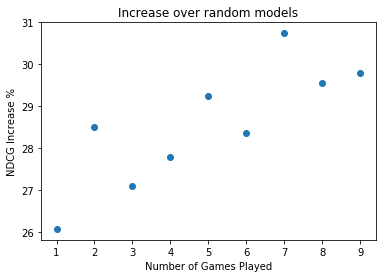

In [44]:
results_5_games_n_increase = [((predicted / random) - 1) * 100 for predicted, random in results_5_games_n_users]

fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), results_5_games_n_increase)
ax.set_title('Increase over random models')
ax.set_xlabel('Number of Games Played')
ax.set_ylabel('NDCG Increase %')
fig.show()
# fig.savefig('../figures/increase_users_for_items_at_5.png')

In [41]:
final_model_dataset = create_dataset(min_games_played=5, min_users_for_game=2)
k_fold_prediction_rdds = fit_and_predict_kfold(als_model, final_model_dataset)
ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
ndcg = sum(ndcgs) / len(ndcgs)
random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
final_model_results = (ndcg, random_ndcg)
final_model_results

split sizes:  (50650, 5289)
Number of users:  2192
train test split size 0:  (43352, 7234)
train test split size 1:  (44218, 6368)
train test split size 2:  (43679, 6907)
train test split size 3:  (43163, 7423)
train test split size 4:  (42762, 7824)


(266.98330676703063, 208.87644498730697)

In [37]:
final_increase = ((final_model_results[0] / final_model_results[1]) - 1) * 100
print('Final Model Increase: {}%'.format(round(final_increase, 3)))

Final Model Increase: 27.523%


## We could look at absolute NDCG increases / decreases.. 
But the size of the dataset will change the outcome vs ideal,  
As well as the absolute DCG (less data, lower gain)

In [23]:
raw_increase_ndcg = np.array(results_5_games_n_users)[:,0]

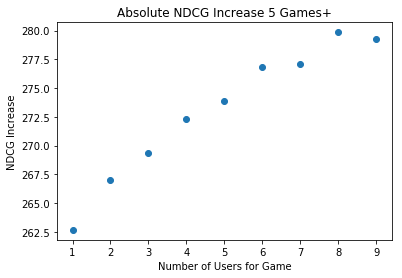

In [42]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), raw_increase_ndcg)
ax.set_title('Absolute NDCG Increase 5 Games+')
ax.set_xlabel('Number of Users for Game')
ax.set_ylabel('NDCG Increase')
fig.show()
# fig.savefig('../figures/absolute_final_increases.png')

In [ ]:
# div by data size
normalized_raw_increase_ndcg= raw_increase_ndcg / 